<a href="https://colab.research.google.com/github/ioannis-toumpoglou/pytorch-repo/blob/main/pretrained_model_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import required packages

In [1]:
# import the required libraries
try:
    import torch
    import torchvision
    import pycocotools
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio pycocotools --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    import pycocotools
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


# 1. Load Sample Images

## 1.1 Load images as Pillow images

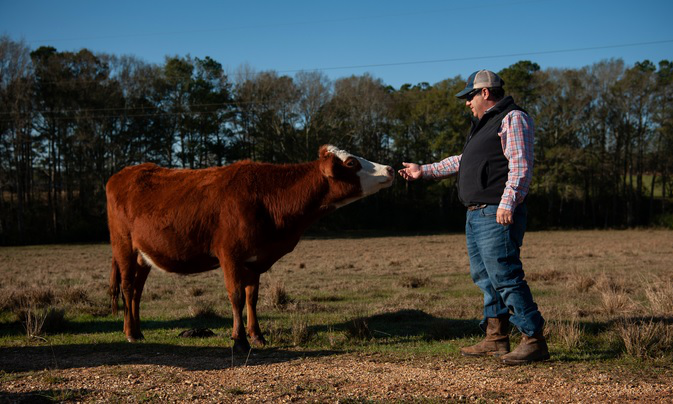

In [39]:
# Display the images
from PIL import Image

holiday = Image.open("man_cow.jpg")
holiday

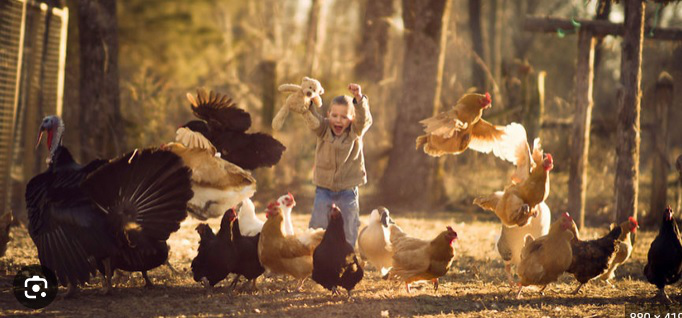

In [40]:
kids_playing = Image.open("barn.jpg")
kids_playing

## 1.2 Convert Pillow images to tensors

In [41]:
from torchvision.transforms.functional import pil_to_tensor

holiday_tensor_int = pil_to_tensor(holiday)
kids_playing_tensor_int = pil_to_tensor(kids_playing)

holiday_tensor_int.shape, kids_playing_tensor_int.shape # Images' shape (color_channels, height, width)

(torch.Size([3, 404, 673]), torch.Size([3, 318, 682]))

## 1.3 Add batch dimension

In [42]:
holiday_tensor_int = holiday_tensor_int.unsqueeze(dim=0)
kids_playing_tensor_int = kids_playing_tensor_int.unsqueeze(dim=0)

holiday_tensor_int.shape, kids_playing_tensor_int.shape

(torch.Size([1, 3, 404, 673]), torch.Size([1, 3, 318, 682]))

## 1.4 Convert images represented as integer (0-255) to floats (0-1)

In [43]:
print(holiday_tensor_int.min(), holiday_tensor_int.max())

holiday_tensor_float = holiday_tensor_int / 255.0
kids_playing_tensor_float = kids_playing_tensor_int / 255.0

print(holiday_tensor_float.min(), holiday_tensor_float.max())

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0.) tensor(1.)


# 2. Load a Pretrained PyTorch Model (Faster R-CNN with ResNet50 Backbone)

In [44]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights

# Download the pretrained weights for FasterRCNN_ResNet50_FPN_V2
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT

# Setup the model with the pretrained weights and send it to the target device
object_detection_model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
object_detection_model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [45]:
 # Set the model to evaluation/prediction mode
object_detection_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# 3. Make Predictions

In [46]:
holiday_preds = object_detection_model(holiday_tensor_float)
holiday_preds

[{'boxes': tensor([[101.6292, 140.7555, 398.5595, 347.1938],
          [397.2558,  70.0828, 550.4113, 364.9933]], grad_fn=<StackBackward0>),
  'labels': tensor([21,  1]),
  'scores': tensor([0.9996, 0.9996], grad_fn=<IndexBackward0>)}]

In [47]:
holiday_preds[0]["boxes"] = holiday_preds[0]["boxes"][holiday_preds[0]["scores"] > 0.8]
holiday_preds[0]["labels"] = holiday_preds[0]["labels"][holiday_preds[0]["scores"] > 0.8]
holiday_preds[0]["scores"] = holiday_preds[0]["scores"][holiday_preds[0]["scores"] > 0.8]
holiday_preds

[{'boxes': tensor([[101.6292, 140.7555, 398.5595, 347.1938],
          [397.2558,  70.0828, 550.4113, 364.9933]], grad_fn=<IndexBackward0>),
  'labels': tensor([21,  1]),
  'scores': tensor([0.9996, 0.9996], grad_fn=<IndexBackward0>)}]

In [48]:
kids_preds = object_detection_model(kids_playing_tensor_float)
kids_preds

[{'boxes': tensor([[642.4775, 208.2005, 681.9483, 303.4708],
          [291.4176,  80.1932, 374.2081, 242.4958],
          [257.8498, 195.3771, 326.5732, 293.0788],
          [357.8958, 207.4838, 396.5652, 279.3893],
          [516.8239, 211.5661, 579.8694, 289.4567],
          [ 25.0685, 116.0215, 190.5151, 295.1025],
          [475.6818, 146.8152, 552.7635, 287.1828],
          [387.2172, 221.9024, 458.9103, 295.5024],
          [311.3241, 205.1418, 363.5339, 298.4160],
          [564.9763, 217.0665, 632.7828, 292.0284]], grad_fn=<StackBackward0>),
  'labels': tensor([16,  1, 16, 16, 16, 16, 16, 16, 16, 16]),
  'scores': tensor([0.9924, 0.9897, 0.9781, 0.9741, 0.9706, 0.9697, 0.9669, 0.9621, 0.9445,
          0.9419], grad_fn=<IndexBackward0>)}]

In [49]:
kids_preds[0]["boxes"] = kids_preds[0]["boxes"][kids_preds[0]["scores"] > 0.8]
kids_preds[0]["labels"] = kids_preds[0]["labels"][kids_preds[0]["scores"] > 0.8]
kids_preds[0]["scores"] = kids_preds[0]["scores"][kids_preds[0]["scores"] > 0.8]
kids_preds

[{'boxes': tensor([[642.4775, 208.2005, 681.9483, 303.4708],
          [291.4176,  80.1932, 374.2081, 242.4958],
          [257.8498, 195.3771, 326.5732, 293.0788],
          [357.8958, 207.4838, 396.5652, 279.3893],
          [516.8239, 211.5661, 579.8694, 289.4567],
          [ 25.0685, 116.0215, 190.5151, 295.1025],
          [475.6818, 146.8152, 552.7635, 287.1828],
          [387.2172, 221.9024, 458.9103, 295.5024],
          [311.3241, 205.1418, 363.5339, 298.4160],
          [564.9763, 217.0665, 632.7828, 292.0284]], grad_fn=<IndexBackward0>),
  'labels': tensor([16,  1, 16, 16, 16, 16, 16, 16, 16, 16]),
  'scores': tensor([0.9924, 0.9897, 0.9781, 0.9741, 0.9706, 0.9697, 0.9669, 0.9621, 0.9445,
          0.9419], grad_fn=<IndexBackward0>)}]

# 4. Visualize Results

## 4.1 Load Target Classes Mapping

In [50]:
import os

if os.path.exists('annotations_trainval2017.zip'):
  print(f'The annotation file already exists. Skipping download...')
else:
  print(f'Downloading the annotation file...')
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip annotations_trainval2017.zip

The annotation file already exists. Skipping download...


In [51]:
from pycocotools.coco import COCO

annFile='annotations/instances_val2017.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=1.25s)
creating index...
index created!


## 4.2 Map Target Category IDs to Labels

In [52]:
holiday_labels = coco.loadCats(holiday_preds[0]["labels"].numpy())
holiday_labels

[{'supercategory': 'animal', 'id': 21, 'name': 'cow'},
 {'supercategory': 'person', 'id': 1, 'name': 'person'}]

In [53]:
kids_labels = coco.loadCats(kids_preds[0]["labels"].numpy())
kids_labels

[{'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'}]

## 4.3 Visualize Bounding Boxes On Original Images

In [54]:
from torchvision.utils import draw_bounding_boxes

holiday_annot_labels = ["{}-{:.2f}".format(label["name"], prob) for label, prob in zip(holiday_labels, holiday_preds[0]["scores"].detach().numpy())]

holiday_output = draw_bounding_boxes(image=holiday_tensor_int[0],
                                     boxes=holiday_preds[0]["boxes"],
                                     labels=holiday_annot_labels,
                                     colors=["red" if label["name"]=="person" else "green" for label in holiday_labels],
                                     width=2
                                    )
holiday_output.shape

torch.Size([3, 404, 673])

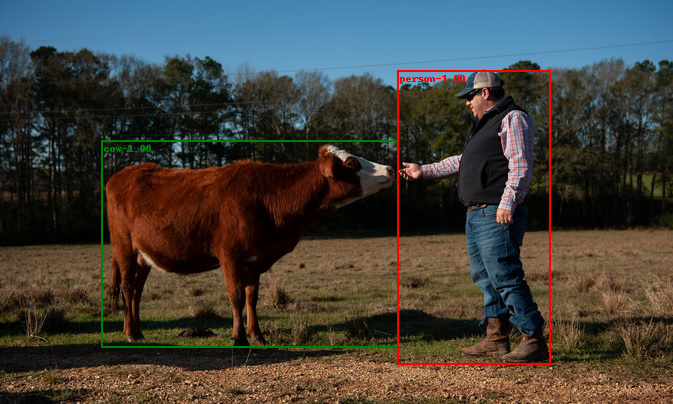

In [55]:
from torchvision.transforms.functional import to_pil_image

to_pil_image(holiday_output)

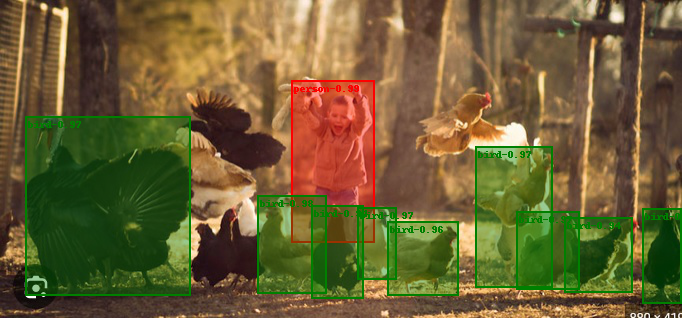

In [56]:
from torchvision.utils import draw_bounding_boxes

kids_annot_labels = ["{}-{:.2f}".format(label["name"], prob) for label, prob in zip(kids_labels, kids_preds[0]["scores"].detach().numpy())]

kids_output = draw_bounding_boxes(image=kids_playing_tensor_int[0],
                             boxes=kids_preds[0]["boxes"],
                             labels=kids_annot_labels,
                             colors=["red" if label["name"]=="person" else "green" for label in kids_labels],
                             width=2,
                             font_size=16,
                             fill=True
                            )
to_pil_image(kids_output)